# Exploratory Data Analysis for YOLO Dataset

## Importing necessary libraries

In [1]:
import datetime
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# Path setup - Adjust the root directory accordingly
cwd = os.getcwd()
project_path = os.path.join(cwd, "..", "..")
dataset_path = os.path.join(project_path, "data", "ships_v10i") # Replace with your dataset folder
splits = ['train', 'valid', 'test']

date_str = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
experiments_path = os.path.join(project_path, "experiments", "eda", date_str)
os.makedirs(experiments_path, exist_ok=True)
eda_summary = {}  # Dictionary to store all EDA results

In [3]:
# Function to get all image and label paths from a given split
def get_image_label_paths(split):
    images_dir = os.path.join(dataset_path, split, "images")
    labels_dir = os.path.join(dataset_path, split, "labels")
    image_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith('.jpg') or f.endswith('.png')])
    label_files = sorted([os.path.join(labels_dir, f) for f in os.listdir(labels_dir) if f.endswith('.txt')])
    return image_files, label_files

In [4]:
# Initialize dictionaries to store data
split_data = {}
for split in splits:
    image_files, label_files = get_image_label_paths(split)
    split_data[split] = {'images': image_files, 'labels': label_files}

In [5]:
# 1. Counting the number of images and labels per split
image_label_stats = {}
for split in splits:
    image_label_stats[split] = {
        'num_images': len(split_data[split]['images']),
        'num_labels': len(split_data[split]['labels'])
    }
eda_summary['image_label_stats'] = image_label_stats

In [6]:
# 2. Bounding box statistics
def parse_yolo_label(label_path):
    with open(label_path, 'r') as file:
        lines = file.readlines()
    return [list(map(float, line.strip().split()[1:])) for line in lines]  # Ignore class ID

In [7]:
def analyze_bounding_boxes(split):
    """
    Analisa bounding boxes, incluindo histogramas e gráficos de dispersão.
    """
    all_bboxes = []  # Armazena tamanhos de bounding boxes
    bboxes_per_image = []  # Quantidade de bounding boxes por imagem
    img_paths = []  # Caminhos das imagens associadas

    for img_path, label_path in tqdm(
        zip(split_data[split]['images'], split_data[split]['labels']),
        desc=f"Processando Bounding Boxes em {split}"
    ):
        bboxes = parse_yolo_label(label_path)
        img = cv2.imread(img_path)
        img_height, img_width = img.shape[:2]  # Dimensões da imagem

        # Converte bounding boxes para pixels
        corrected_bboxes = [(bbox[2] * img_width, bbox[3]
                             * img_height) for bbox in bboxes]
        bboxes_per_image.append(len(bboxes))
        all_bboxes.extend(corrected_bboxes)
        img_paths.extend([img_path] * len(bboxes))

    # DataFrame com os bounding boxes
    bboxes_df = pd.DataFrame(all_bboxes, columns=['width', 'height'])
    bboxes_df['image_path'] = img_paths  # Adiciona caminho das imagens

    # Estatísticas
    stats = {
        'mean_bboxes_per_image': np.mean(bboxes_per_image),
        'median_bboxes_per_image': np.median(bboxes_per_image),
        'mean_bbox_size_pixels': bboxes_df[['width', 'height']].mean().values.tolist(),
        'median_bbox_size_pixels': bboxes_df[['width', 'height']].median().values.tolist(),
        'stdev_bbox_size_pixels': bboxes_df[['width', 'height']].std().values.tolist()
    }

    # Histogramas
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(bboxes_df['width'], bins=30,
             color='blue', alpha=0.7, label='Largura')
    plt.axvline(bboxes_df['width'].mean(), color='red', linestyle='--',
                label=f'Média: {bboxes_df["width"].mean():.2f}')
    plt.axvline(bboxes_df['width'].median(), color='green', linestyle='--',
                label=f'Mediana: {bboxes_df["width"].median():.2f}')
    plt.title(f"Distribuição de Larguras ({split.capitalize()})")
    plt.xlabel('Largura (pixels)')
    plt.ylabel('Frequência')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(bboxes_df['height'], bins=30,
             color='orange', alpha=0.7, label='Altura')
    plt.axvline(bboxes_df['height'].mean(), color='red', linestyle='--',
                label=f'Média: {bboxes_df["height"].mean():.2f}')
    plt.axvline(bboxes_df['height'].median(), color='green', linestyle='--',
                label=f'Mediana: {bboxes_df["height"].median():.2f}')
    plt.title(f"Distribuição de Alturas ({split.capitalize()})")
    plt.xlabel('Altura (pixels)')
    plt.ylabel('Frequência')
    plt.legend()

    plt.tight_layout()
    hist_plot_path = os.path.join(
        experiments_path, f"{split}_distribuicao_bboxes.png")
    plt.savefig(hist_plot_path)
    plt.show()

    print(f"Gráfico de histogramas salvo em {hist_plot_path}")

    # Scatter plot
    plt.figure(figsize=(8, 8))
    plt.scatter(bboxes_df['width'], bboxes_df['height'],
                alpha=0.5, color='purple', edgecolor='k')
    plt.axhline(bboxes_df['height'].mean(), color='blue', linestyle='--',
                label=f'Média Altura: {bboxes_df["height"].mean():.2f}')
    plt.axvline(bboxes_df['width'].mean(), color='red', linestyle='--',
                label=f'Média Largura: {bboxes_df["width"].mean():.2f}')
    plt.title(f"Dispersão de Largura vs Altura ({split.capitalize()})")
    plt.xlabel('Largura (pixels)')
    plt.ylabel('Altura (pixels)')
    plt.legend()
    scatter_plot_path = os.path.join(
        experiments_path, f"{split}_dispersao_bboxes.png")
    plt.savefig(scatter_plot_path)
    plt.show()

    print(f"Gráfico de dispersão salvo em {scatter_plot_path}")

    return stats, bboxes_df

Processando Bounding Boxes em train: 2320it [00:33, 68.74it/s]


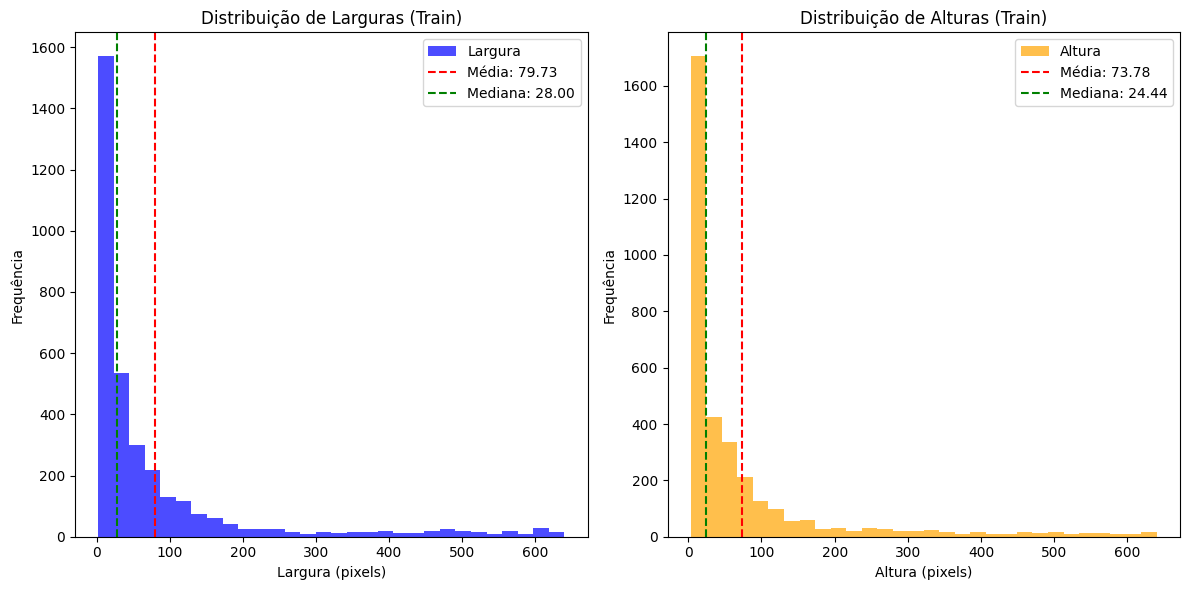

Gráfico de histogramas salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/train_distribuicao_bboxes.png


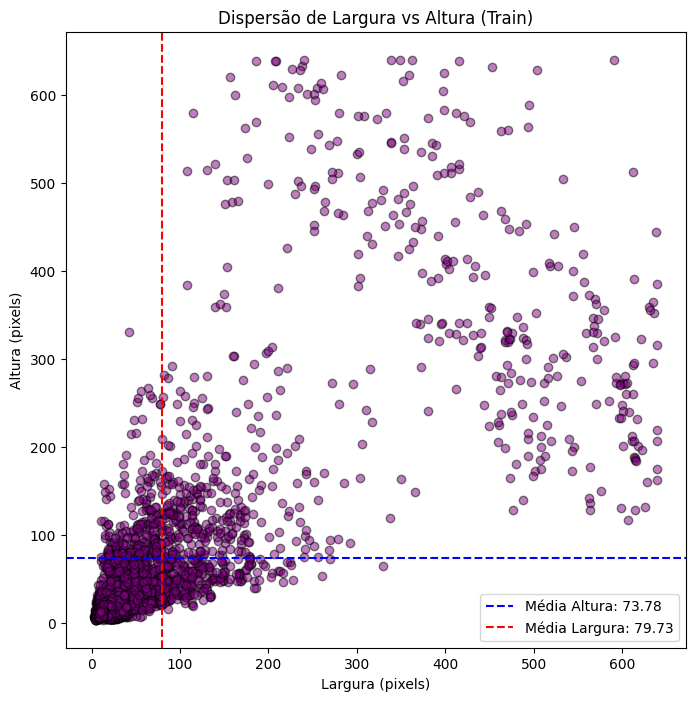

Gráfico de dispersão salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/train_dispersao_bboxes.png


Processando Bounding Boxes em valid: 521it [00:07, 71.20it/s]


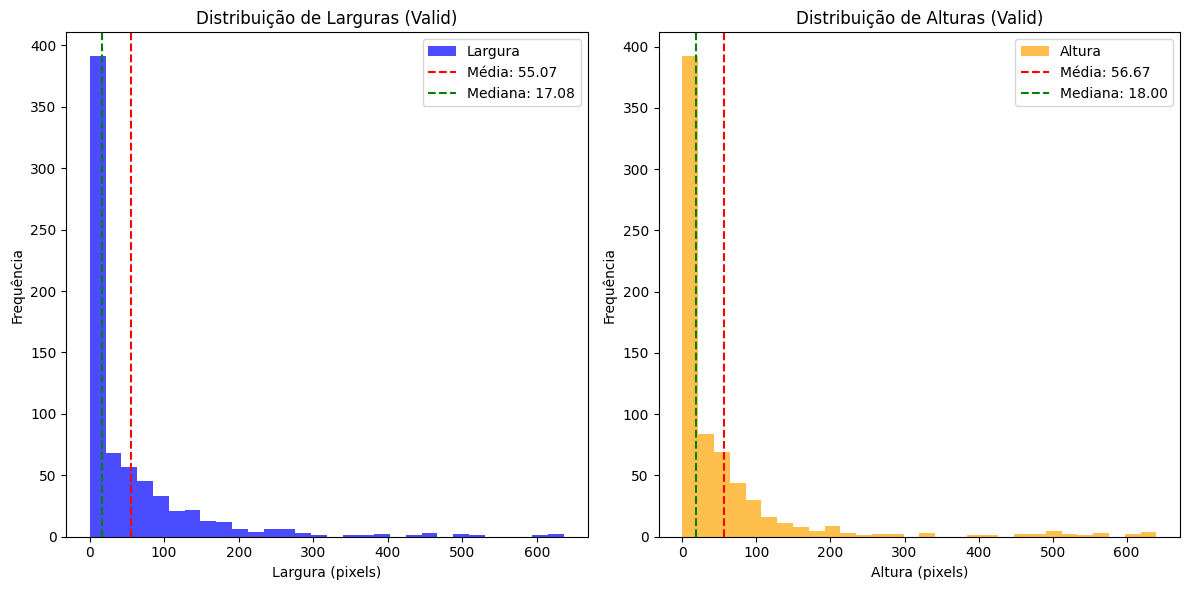

Gráfico de histogramas salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/valid_distribuicao_bboxes.png


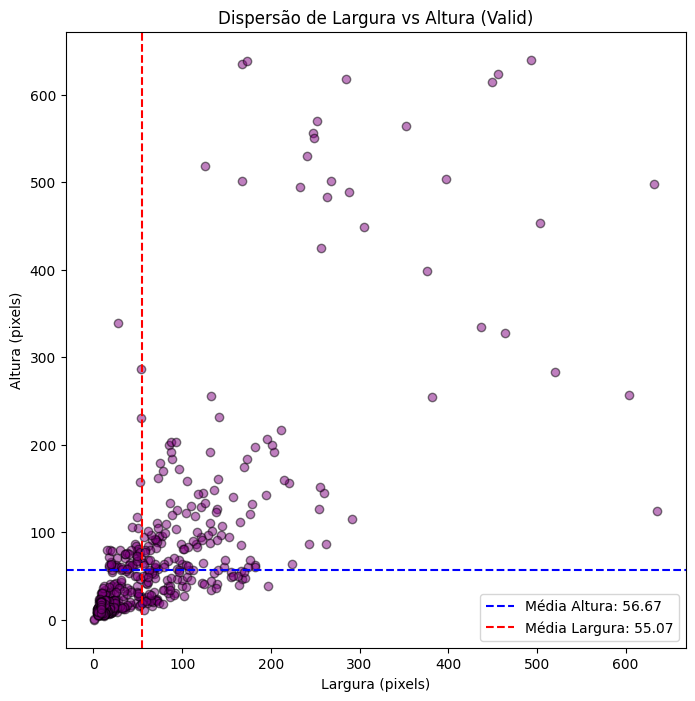

Gráfico de dispersão salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/valid_dispersao_bboxes.png


Processando Bounding Boxes em test: 417it [00:05, 72.41it/s]


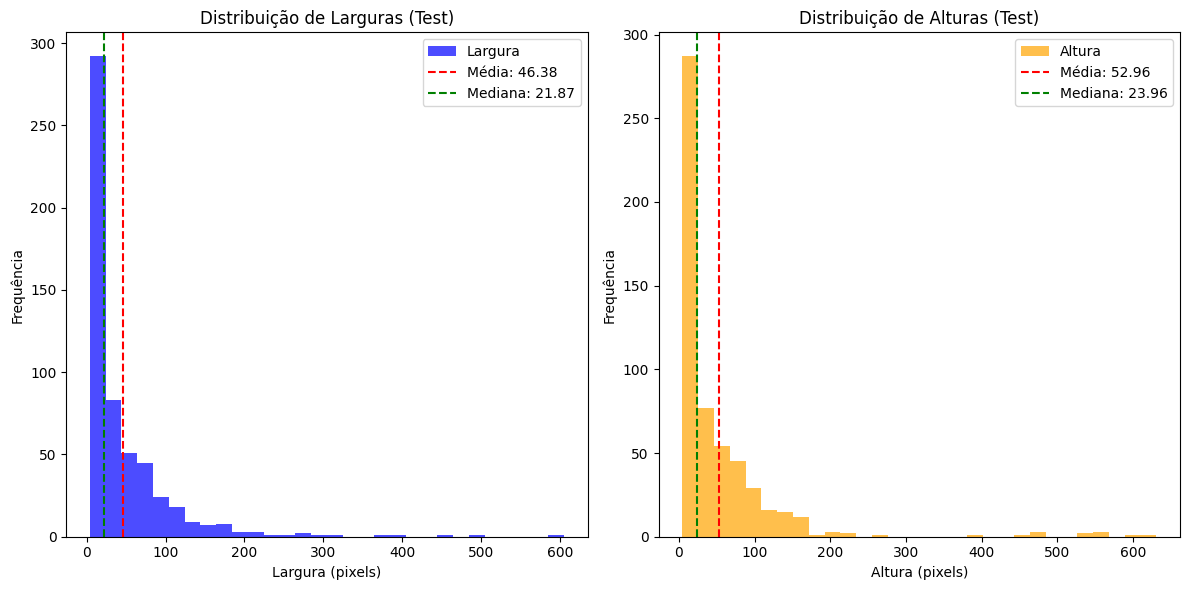

Gráfico de histogramas salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/test_distribuicao_bboxes.png


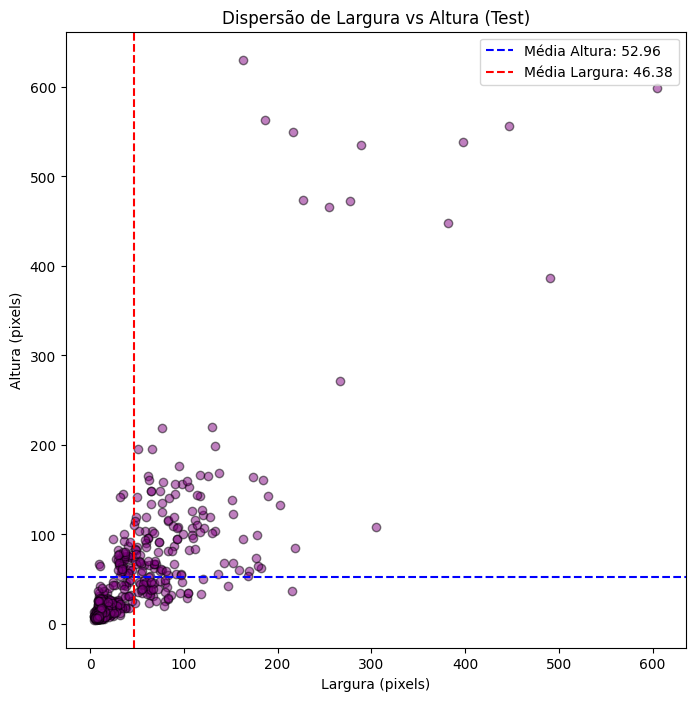

Gráfico de dispersão salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/test_dispersao_bboxes.png


In [8]:
# Processar bounding boxes e obter DataFrame para cada split
bbox_dfs = {}
stats = {}

for split in splits:
    stats, bboxes_df = analyze_bounding_boxes(split)
    stats[split] = stats
    bbox_dfs[split] = bboxes_df  # Armazena o DataFrame de bounding boxes

eda_summary['bbox_stats'] = stats

In [9]:
def analyze_image_sizes(split):
    """
    Analisa tamanhos das imagens, incluindo média, mediana, variância.
    Plota histogramas e um scatter plot das dimensões.
    """
    resolutions = []
    for image_path in tqdm(split_data[split]['images'], desc=f"Analisando resoluções de {split}"):
        img = cv2.imread(image_path)
        if img is not None:
            resolutions.append(img.shape[:2])  # Altura, Largura
    resolutions = np.array(resolutions)

    # Estatísticas
    stats = {
        'mean_resolution': np.mean(resolutions, axis=0).tolist(),
        'median_resolution': np.median(resolutions, axis=0).tolist(),
        'stdev_resolution': np.std(resolutions, axis=0).tolist()
    }

    # Alturas e larguras separadas
    heights, widths = resolutions[:, 0], resolutions[:, 1]

    # Histogramas
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=30, color='blue', alpha=0.7, label='Alturas')
    plt.axvline(np.mean(heights), color='red', linestyle='--',
                label=f'Média: {np.mean(heights):.2f}')
    plt.axvline(np.median(heights), color='green', linestyle='--',
                label=f'Mediana: {np.median(heights):.2f}')
    plt.title(f"Distribuição de Alturas ({split.capitalize()})")
    plt.xlabel('Altura (pixels)')
    plt.ylabel('Frequência')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=30, color='orange', alpha=0.7, label='Larguras')
    plt.axvline(np.mean(widths), color='red', linestyle='--',
                label=f'Média: {np.mean(widths):.2f}')
    plt.axvline(np.median(widths), color='green', linestyle='--',
                label=f'Mediana: {np.median(widths):.2f}')
    plt.title(f"Distribuição de Larguras ({split.capitalize()})")
    plt.xlabel('Largura (pixels)')
    plt.ylabel('Frequência')
    plt.legend()

    plt.tight_layout()
    hist_plot_path = os.path.join(
        experiments_path, f"{split}_distribuicao_resolucoes.png")
    plt.savefig(hist_plot_path)
    plt.show()

    print(f"Gráfico de histogramas salvo em {hist_plot_path}")

    # Scatter plot
    plt.figure(figsize=(8, 8))
    plt.scatter(widths, heights, alpha=0.5, marker='.',
                color='purple', edgecolor='k')
    plt.axhline(np.mean(heights), color='blue', linestyle='--',
                label=f'Média Altura: {np.mean(heights):.2f}')
    plt.axvline(np.mean(widths), color='red', linestyle='--',
                label=f'Média Largura: {np.mean(widths):.2f}')
    plt.title(f"Dispersão de Altura vs Largura ({split.capitalize()})")
    plt.xlabel('Largura (pixels)')
    plt.ylabel('Altura (pixels)')
    plt.legend()
    scatter_plot_path = os.path.join(
        experiments_path, f"{split}_dispersao_resolucoes.png")
    plt.savefig(scatter_plot_path)
    plt.show()

    print(f"Gráfico de dispersão salvo em {scatter_plot_path}")

    return stats

Analisando resoluções de train: 100%|██████████| 2320/2320 [00:15<00:00, 146.03it/s]


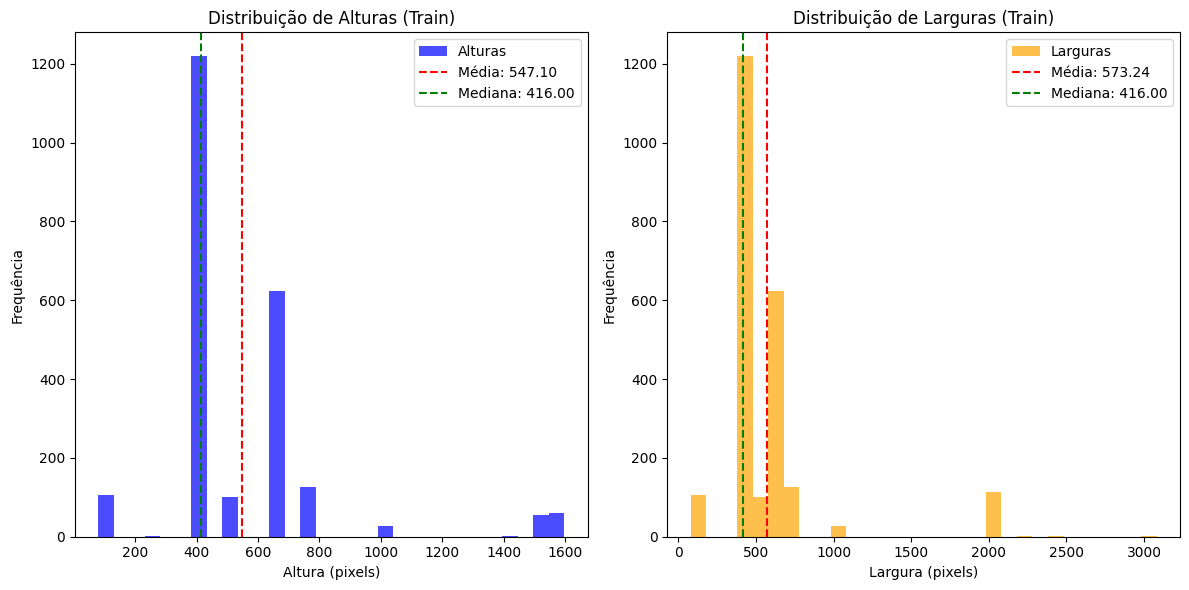

Gráfico de histogramas salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/train_distribuicao_resolucoes.png


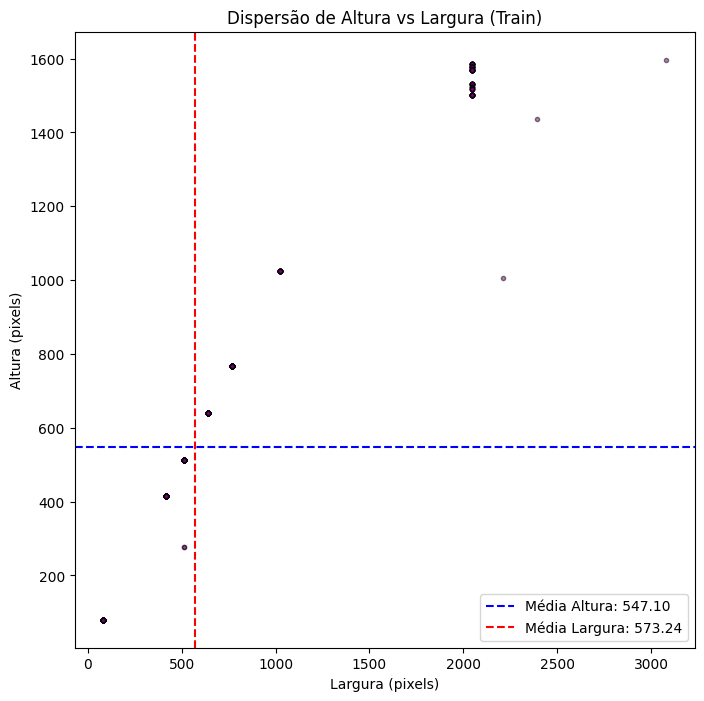

Gráfico de dispersão salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/train_dispersao_resolucoes.png


Analisando resoluções de valid: 100%|██████████| 521/521 [00:03<00:00, 157.15it/s]


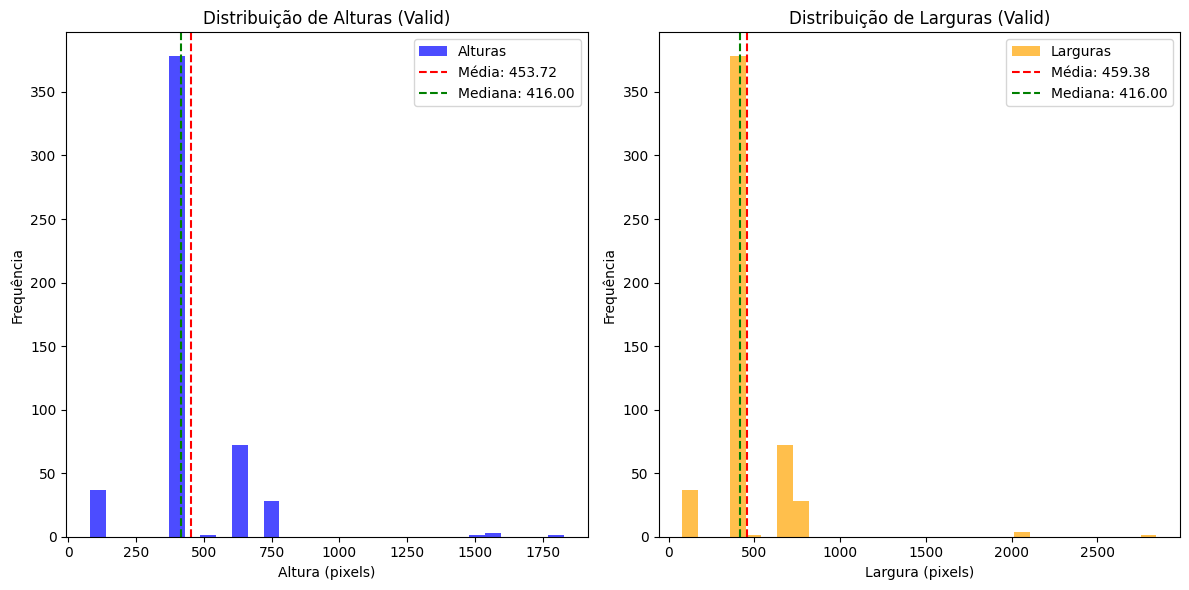

Gráfico de histogramas salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/valid_distribuicao_resolucoes.png


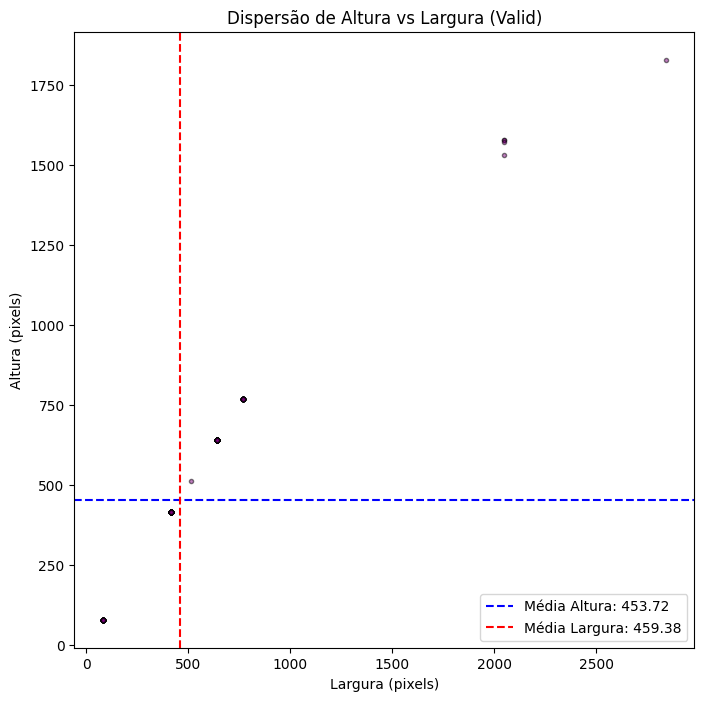

Gráfico de dispersão salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/valid_dispersao_resolucoes.png


Analisando resoluções de test: 100%|██████████| 417/417 [00:02<00:00, 148.14it/s]


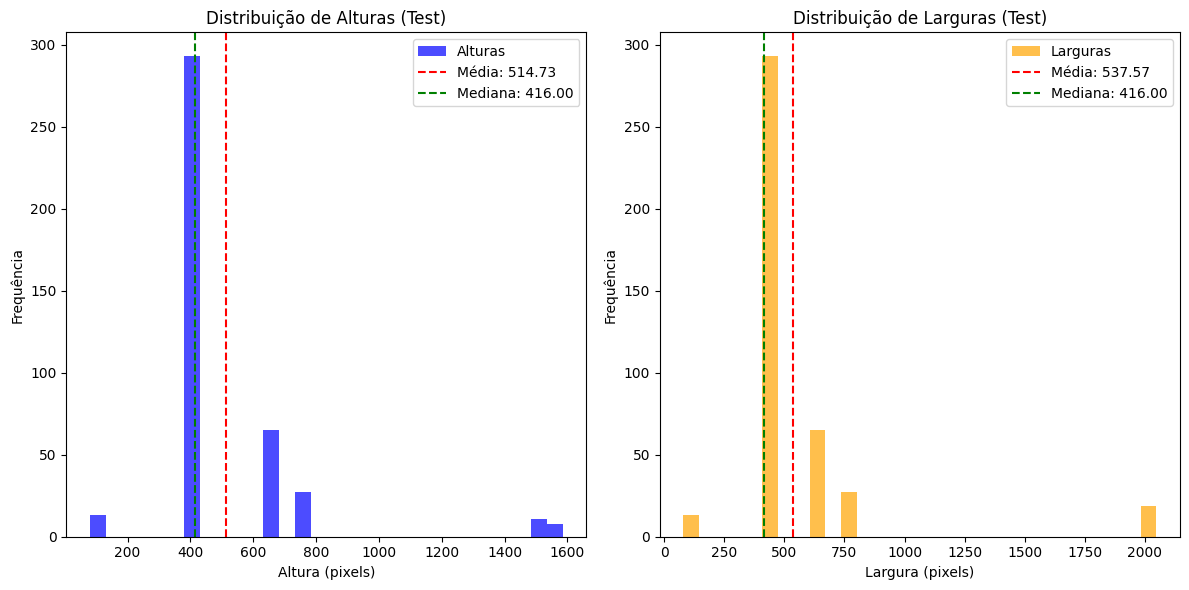

Gráfico de histogramas salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/test_distribuicao_resolucoes.png


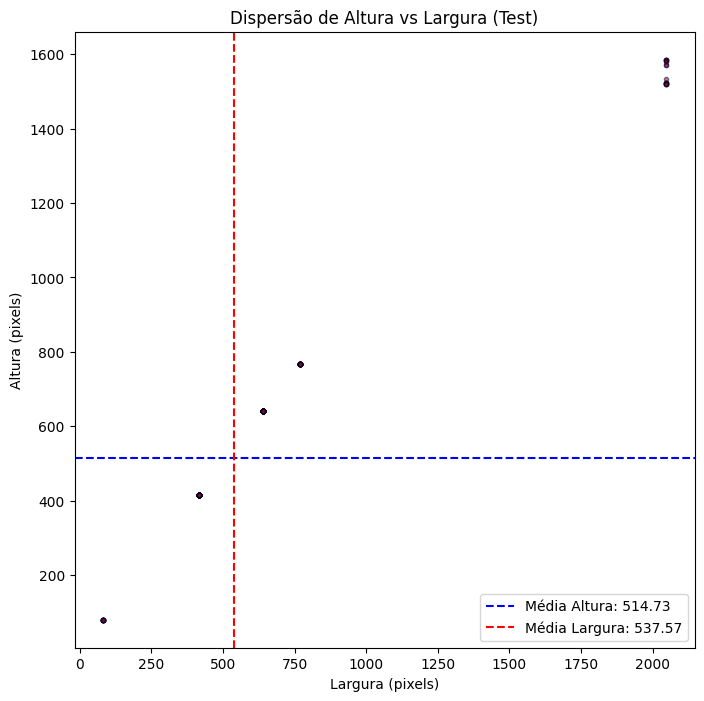

Gráfico de dispersão salvo em /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/test_dispersao_resolucoes.png


In [10]:
# Processar para todos os splits e salvar resultados
image_stats_with_variance = {split: analyze_image_sizes(split) for split in splits}
eda_summary['image_stats'] = image_stats_with_variance

In [11]:
def scatter_plot_with_percentiles(bboxes_df, percentiles=[25, 50, 75], split_name="dataset"):
    """
    Gera um scatter plot dos bounding boxes com pontos coloridos de acordo com os percentis combinados.
    """
    # Calcula os percentis para largura e altura
    width_percentiles = np.percentile(bboxes_df['width'], percentiles)
    height_percentiles = np.percentile(bboxes_df['height'], percentiles)

    # Função para determinar a cor com base no percentil combinado
    def get_combined_percentile_category(width, height):
        for i, (w_p, h_p) in enumerate(zip(width_percentiles, height_percentiles)):
            if width <= w_p and height <= h_p:
                return i  # Retorna o índice do percentil
        return len(percentiles)  # Para pontos acima do maior percentil

    # Calcula o percentil de cada bounding box
    bboxes_df['percentile_category'] = bboxes_df.apply(
        lambda row: get_combined_percentile_category(row['width'], row['height']), axis=1
    )

    # Definições de cores para cada categoria
    colors = ['blue', 'green', 'orange', 'red']
    color_labels = [f"≤ {p}º Percentil" for p in percentiles] + \
        [f"> {percentiles[-1]}º Percentil"]

    # Scatter plot
    plt.figure(figsize=(10, 8))
    for category, color, label in zip(range(len(colors)), colors, color_labels):
        category_data = bboxes_df[bboxes_df['percentile_category'] == category]
        plt.scatter(category_data['width'], category_data['height'],
                    alpha=0.5, color=color, edgecolor='k', label=label)

    # Configurações do plot
    plt.title(f"Gráfico de Dispersão de Bounding Boxes por Percentil ({
              split_name.capitalize()})")
    plt.xlabel('Largura (pixels)')
    plt.ylabel('Altura (pixels)')
    plt.legend(loc='best', title="Categorias de Percentil")
    plt.grid(alpha=0.3)

    # Salvar o gráfico
    scatter_path = os.path.join(
        experiments_path, f"{split_name}_bboxes_scatter_colored_by_percentiles.png")
    plt.savefig(scatter_path)
    plt.show()

    print(f"Gráfico de dispersão com percentis salvo em: {scatter_path}")

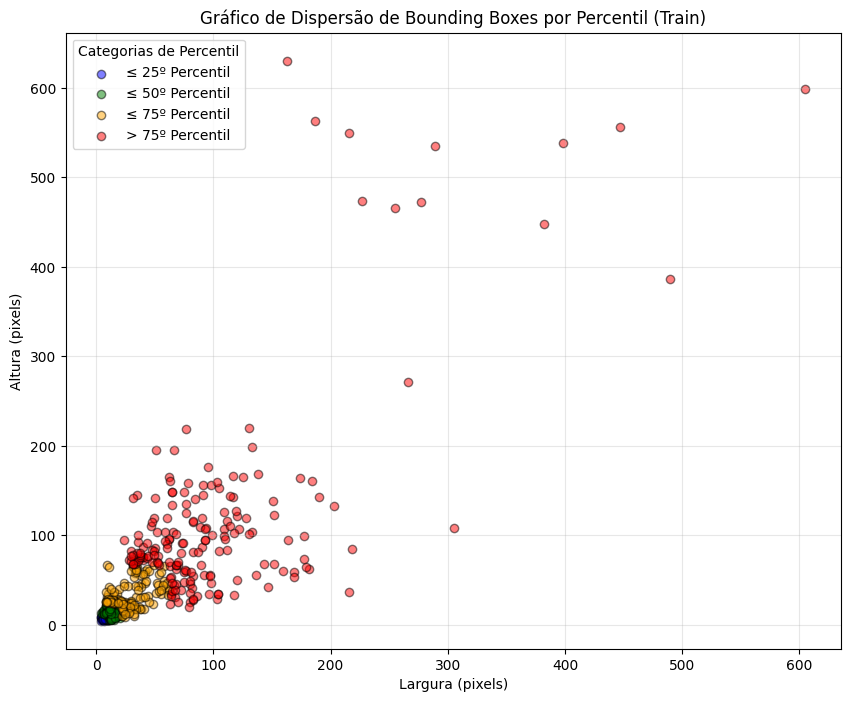

Gráfico de dispersão com percentis salvo em: /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/train_bboxes_scatter_colored_by_percentiles.png


In [12]:
scatter_plot_with_percentiles(bboxes_df, percentiles=[25, 50, 75], split_name="train")

In [13]:
def display_cropped_images_by_percentile(cropped_image_dir, percentiles=[25, 50, 75], n_images=5):
    """
    Displays n cropped images for each percentile range based on bounding box dimensions.

    Args:
        cropped_image_dir (str): Path to the directory containing cropped images.
        percentiles (list): List of percentiles to classify the bounding boxes.
        n_images (int): Number of images to display for each percentile range.
    """
    # Navigate the directory and collect image details
    image_files = [os.path.join(cropped_image_dir, f) for f in os.listdir(
        cropped_image_dir) if f.endswith(('.jpg', '.png'))]

    # Collect width and height information for each image
    bboxes_data = []
    for img_path in tqdm(image_files, desc="Analyzing cropped images"):
        img = cv2.imread(img_path)
        if img is not None:
            height, width = img.shape[:2]
            bboxes_data.append(
                {'width': width, 'height': height, 'image_path': img_path})

    # Create a DataFrame for analysis
    bboxes_df = pd.DataFrame(bboxes_data)

    # Calculate percentiles for width and height
    width_percentiles = np.percentile(bboxes_df['width'], percentiles)
    height_percentiles = np.percentile(bboxes_df['height'], percentiles)

    # Function to determine the percentile range
    def get_percentile_interval(width, height):
        for i, (w_p, h_p) in enumerate(zip(width_percentiles, height_percentiles)):
            if width <= w_p and height <= h_p:
                if i == 0:
                    return f"< {percentiles[i]}%"
                else:
                    return f"{percentiles[i-1]}% ≤ Percentil < {percentiles[i]}%"
        # For points above the largest percentile
        return f"≥ {percentiles[-1]}%"

    # Add a column to the DataFrame with the percentile interval
    bboxes_df['percentile_interval'] = bboxes_df.apply(
        lambda row: get_percentile_interval(row['width'], row['height']), axis=1
    )

    # Display cropped images for each percentile range
    for interval in bboxes_df['percentile_interval'].unique():
        category_data = bboxes_df[bboxes_df['percentile_interval'] == interval]

        print(f"\nExibindo {min(n_images, len(category_data))
                            } imagens recortadas para o intervalo: {interval}")
        plt.figure(figsize=(15, 10))

        for i, (_, row) in enumerate(category_data.iterrows()):
            if i >= n_images:
                break
            cropped_img_path = row['image_path']

            # Load the cropped image
            img = cv2.imread(cropped_img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Show the image
            plt.subplot(1, n_images, i + 1)
            plt.imshow(img)
            plt.title(interval)  # Title in Portuguese
            plt.axis("off")

        plt.tight_layout()
        plt.savefig(os.path.join(
            experiments_path, f"cropped_images_{interval}.png"))
        plt.show()

Analyzing cropped images: 100%|██████████| 3406/3406 [00:16<00:00, 210.54it/s]



Exibindo 5 imagens recortadas para o intervalo: 50% ≤ Percentil < 75%


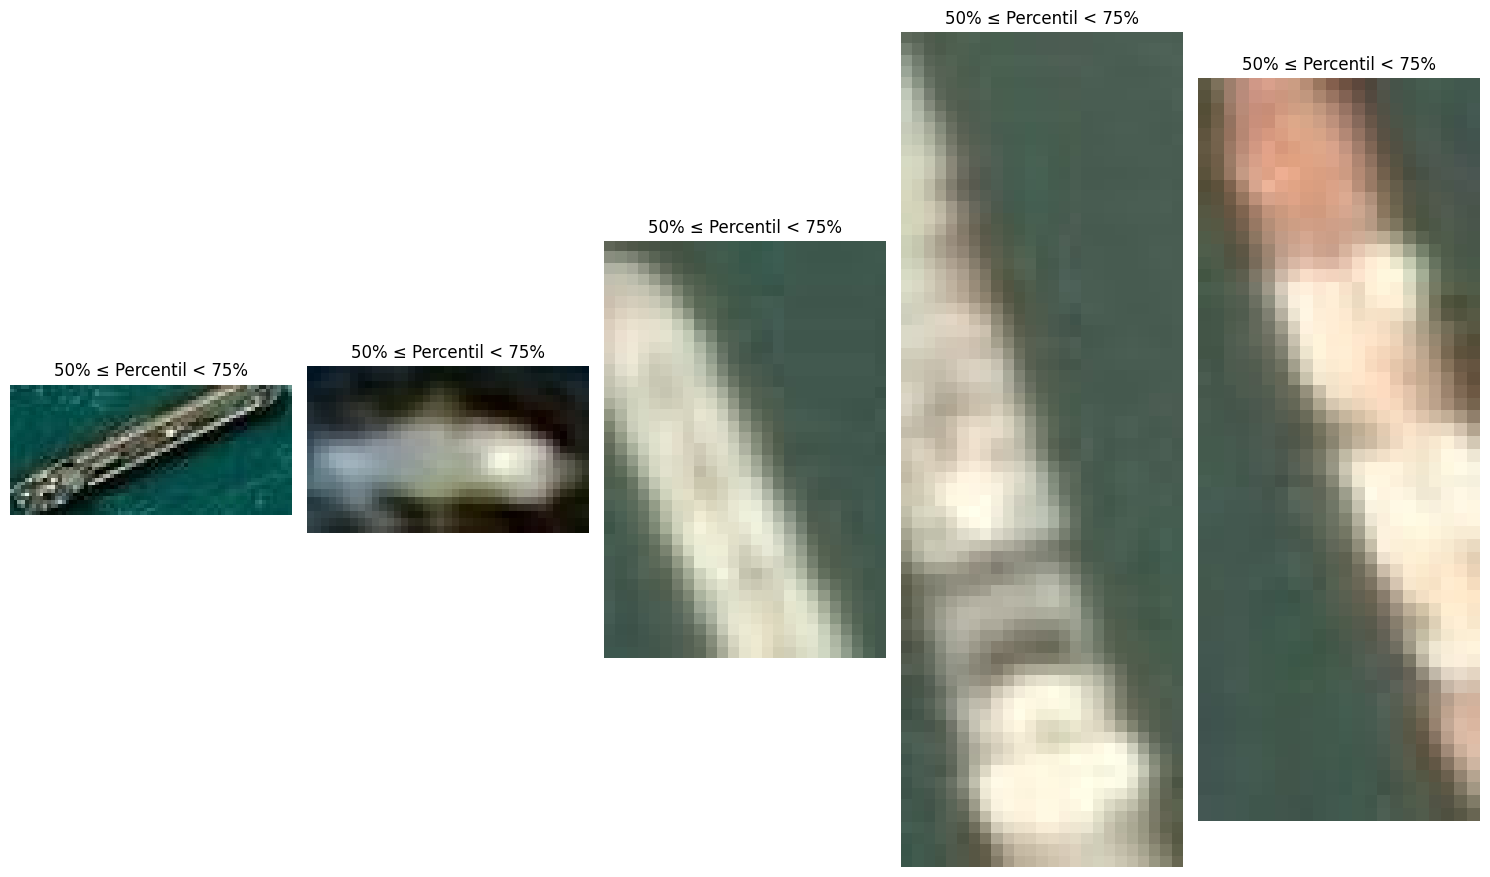


Exibindo 5 imagens recortadas para o intervalo: ≥ 75%


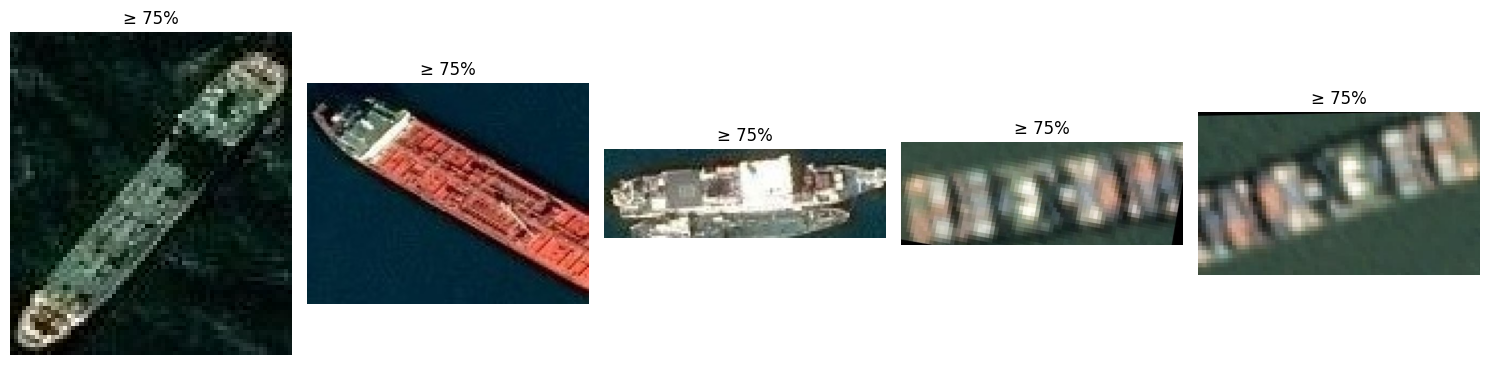


Exibindo 5 imagens recortadas para o intervalo: 25% ≤ Percentil < 50%


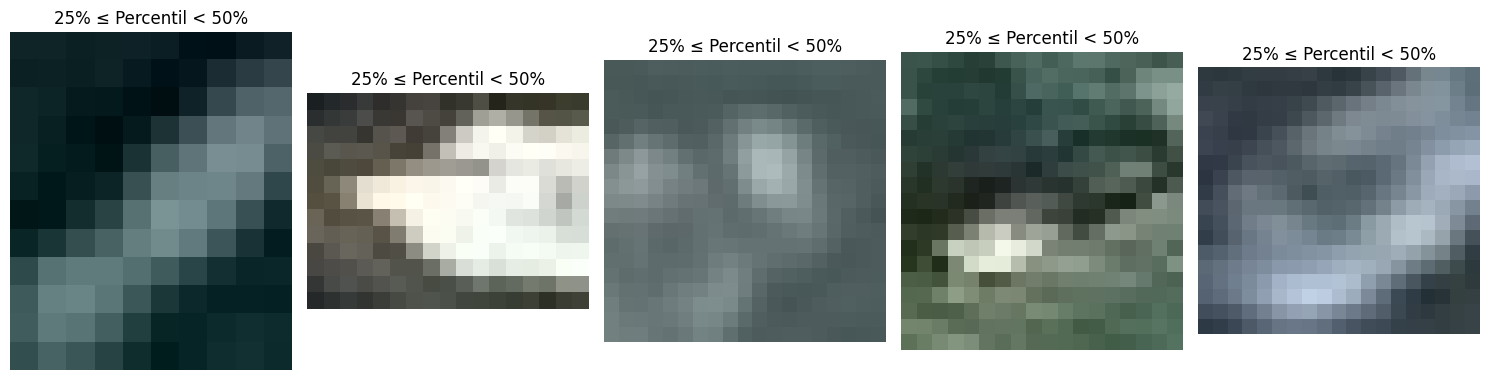


Exibindo 5 imagens recortadas para o intervalo: < 25%


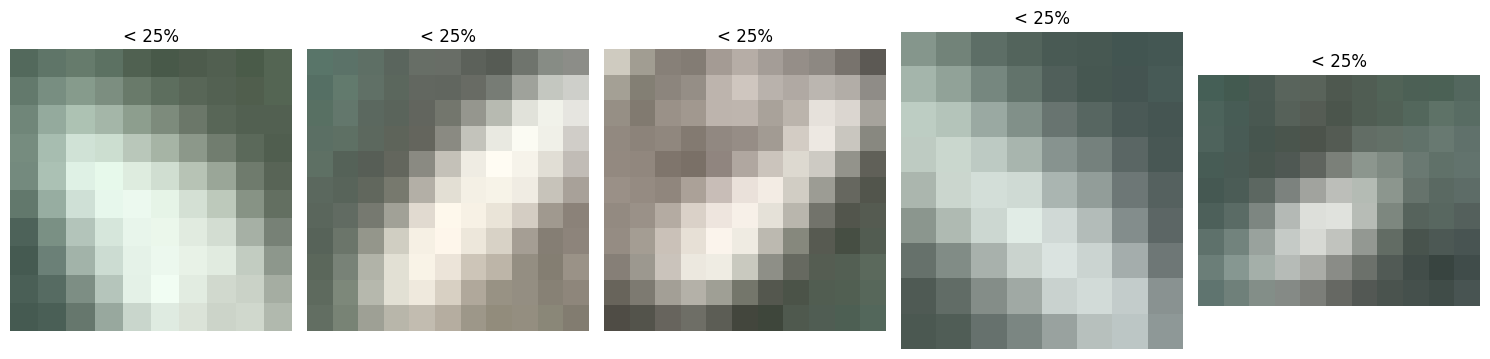

In [ ]:
display_cropped_images_by_percentile(os.path.join(dataset_path, 'cropped'), percentiles=[25, 50, 75], n_images=5)

In [17]:
# 4. Save EDA summary to Markdown file
eda_summary_md_path = os.path.join(experiments_path, 'eda_summary.md')

print(eda_summary)

{'image_label_stats': {'train': {'num_images': 2320, 'num_labels': 2327}, 'valid': {'num_images': 521, 'num_labels': 521}, 'test': {'num_images': 417, 'num_labels': 417}}, 'bbox_stats': {'mean_bboxes_per_image': np.float64(1.328537170263789), 'median_bboxes_per_image': np.float64(1.0), 'mean_bbox_size_pixels': [46.37622743682311, 52.95750902527076], 'median_bbox_size_pixels': [21.869999999999997, 23.959999999999997], 'stdev_bbox_size_pixels': [62.99681466753373, 82.44381338788085], 'test': {...}}, 'image_stats': {'train': {'mean_resolution': [547.1038793103448, 573.2426724137931], 'median_resolution': [416.0, 416.0], 'stdev_resolution': [276.52182987739354, 375.64208385352725]}, 'valid': {'mean_resolution': [453.7236084452975, 459.38003838771596], 'median_resolution': [416.0, 416.0], 'stdev_resolution': [184.82930964454155, 226.9171289301859]}, 'test': {'mean_resolution': [514.7338129496403, 537.5731414868105], 'median_resolution': [416.0, 416.0], 'stdev_resolution': [260.5131877486759

In [18]:
def dict_to_markdown(eda_summary):
    """
    Converts a nested dictionary into a markdown-formatted string.
    """
    md_content = "# Exploratory Data Analysis Summary\n\n"
    for section, stats in eda_summary.items():
        md_content += f"## {section.replace('_', ' ').title()}\n\n"
        if isinstance(stats, dict):
            # Check if this level contains splits like 'train', 'valid', 'test'
            if all(isinstance(value, dict) for value in stats.values()):
                for split, split_stats in stats.items():
                    md_content += f"### {split.capitalize()}\n\n"
                    for key, value in split_stats.items():
                        md_content += f"- **{key.replace('_', ' ').title()}**: {
                            value}\n"
                    md_content += "\n"
            else:
                # Handle non-split dictionaries
                for key, value in stats.items():
                    md_content += f"- **{key.replace('_',
                                                     ' ').title()}**: {value}\n"
                md_content += "\n"
        else:
            md_content += f"{stats}\n\n"
    return md_content

In [19]:
# Write EDA summary to markdown
with open(eda_summary_md_path, 'w') as file:
    file.write(dict_to_markdown(eda_summary))

print(f"EDA summary saved to {eda_summary_md_path}")

EDA summary saved to /mnt/c/Users/Ricardo/Documents/Development/tcc-1/tcc/autoencoders/../../experiments/eda/2024-12-18_00-10-45/eda_summary.md
